# **Análisis, Visualización y Curación de Datos**

# Consigna 2

#### Determinar la cantidad de diálogos del dataset, cantidad de tutores, y cantidad de estudiantes. Luego, determinar cuántos turnos hay del tutor y cuántos del estudiante en total y en promedio por diálogo. Graficar la distribución.

## Importación de modulos
---

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from columns_to_keep import C2K
from type_to_fix import T2F

## Carga de la tabla de metadata
---

In [ ]:
data_dir = os.path.join('..', 'dataset')
data_file_name = 'datadump-20150801-20171219.csv'
full_data_file_name = os.path.join(data_dir, data_file_name)
df = pd.read_csv(full_data_file_name)
display(df.shape)

(63265, 111)

## Preprocesamiento o curación de la metadata

In [ ]:
# Remuevo espacios al inicio y final del nombre de la columna
df.columns = [column.strip() for column in df.columns]

# Tomo solo las columnas que vamos a necesitar
df = df[C2K]

# Se corrigen los tipos de los datos 
df = df.astype(T2F)

display(df.shape)

(63265, 39)

## Carga la tabla de mensajes preprocesados
---

**Tamaño del dataset de train**

In [ ]:
data_file_name = 'train_yup_messages_preprocessed.csv'
full_data_file_name = os.path.join(data_dir, data_file_name)
df_messages = pd.read_csv(full_data_file_name)
print("El dataset de train con los mensajes preprocesados tiene", df_messages.shape[0], " filas y ", df_messages.shape[1], " columnas")

(7441, 6)

In [ ]:
print("El dataset de train con los mensajes preprocesados tiene", df_messages.shape[0], " filas y ", df_messages.shape[1], " columnas")

El dataset de train con los mensajes preprocesados tiene 1102917  filas y  6  columnas


## Cálculos
---
A continuación, se calcula la cantidad de sensiones únicas del dataset de mensajes preprocesados y la cantidad de sesiones en el dataset de metadata, los mismos no coinciden ya que actualmente en el caso de los mensajes preprocesados se trabaja con el dataset de entrenamiento en lugar de trabajar con el dataset completo. Por lo que se opta por tomar como fuente el dataset de metadata para este propósito.

In [ ]:
n_dialogos = df_messages.session_id.unique().shape[0]
n_sessions = df.session_id.shape[0]
n_tutors = df.tutor_id.unique().shape[0]
n_students = df.student_id.unique().shape[0]

display(f'>> El número de diálogos computados a partir del dataset de mensajes preprocesados es de {n_dialogos}, mientras que el número de diálogos computados a partir del archivo de metadata es: {n_sessions}.')
display(f'>> Además la cantidad total de tutores es de {n_tutors} y la de estudiantes de {n_students}.')

'>> El número de diálogos computados a partir del dataset de mensajes preprocesados es de 17987, mientras que el número de diálogos computados a partir del archivo de metadata es: 63265.'

'>> Además la cantidad total de tutores es de 150 y la de estudiantes de .16808'

### Cálculo del número de turnos de estudiantes y tutores por diálogo
### Pasos:

1. Se  calcula el número de turnos agrupados por `session_id` y `sent_from`
2. Se descartan las filas que no son turnos del tutor ni del estudiante, es decir, que corresponden al bot. 
3. Se crea una nueva columna con el cálculo realizado. 
4. Se remueven las columnas no necesarias como el tipo de contenido y el texto del diálogo, etc. 

In [ ]:
st_turnos_total= df_messages.groupby(['session_id']).count()
print('El total de turnos es de ', st_turnos_total.shape[0], '.\n')

# 1.
st_turnos = df_messages.groupby(['session_id','sent_from']).count().reset_index()

# 2. Turnos solamente de tutores y estudiantes
st_turnos = st_turnos[st_turnos.sent_from.isin(['student', 'tutor'])]

# 3. 
st_turnos['counts'] = st_turnos['text']

# 4.
st_turnos.drop(columns=['created_at', 'sent_to', 'content_type', 'text'], inplace=True)
display(st_turnos)

El total de turnos es de  17987 .



,session_id,sent_from,counts
0,299889,student,7
3,299889,tutor,13
4,299890,student,40
7,299890,tutor,44
8,299891,student,6
...,...,...,...
74145,326165,student,14
74146,326165,tutor,11
74148,326166,student,5
74150,326166,tutor,9


### Cálculo del número total de turnos por diálogo

### Pasos:

5. Agrupar 'st_turnos' por `session_id` y luego se suman las coincidencias.  

In [ ]:
# 5.
turnos = st_turnos.groupby('session_id').sum()
display(turnos)

,counts
session_id,
299889,20
299890,84
299891,9
299892,49
299893,36
...,...
326161,14
326163,42
326165,25


### Cálculo del promedio de turnos

1. Se calcula el promedio de turnos discriminado por tutor y estudiante.
2. Por último, se calcula el promedio total de turnos.

In [ ]:
# 1.
mean_disc = st_turnos.groupby('sent_from').mean().drop(columns='session_id')
mean_tutors = mean_disc.loc['tutor','counts']
mean_students = mean_disc.loc['student','counts']
# se calcula la mediana sólo para conocer un poco más de la distribución
mediana_disc = st_turnos.groupby('sent_from').median().drop(columns='session_id')
print('Mediana de turnos','\n')
print(mediana_disc)

# 2. promedio total
# mean_total = turnos.counts.mean()
mean_total = mean_tutors + mean_students

print(f'\nEl Promedio de turnos por tutores de {mean_tutors: .2f}, mientras que el Promedio de turnos por estudiantes es de {mean_students: .2f}')
display(f'>> Promedio total de turnos entre estudiantes y tutores es de {mean_total:.2f}')


Mediana de turnos 

           counts
sent_from        
student      14.0
tutor        21.0

El Promedio de turnos por tutores de  36.22, mientras que el Promedio de turnos por estudiantes es de  23.85


'>> Promedio total de turnos entre estudiantes y tutores es de 60.07'

### Histograma del nro. total de turnos por diálogo

$$
Nt_{total} = Nt_{tutors} + Nt_{students}
$$

donde $Nt$ es el número total de turnos por diálogo, teniendo en cuenta los turnos por tutor y por estudiantes.

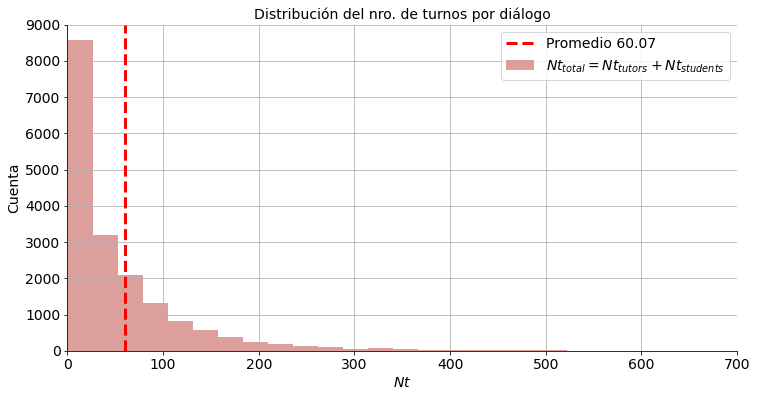

In [ ]:
plt.figure(figsize=(12,6))
plt.plot([mean_total, mean_total], [0,9000], '--r', linewidth=3, label=f'Promedio {mean_total:.2f}')
sns.distplot(turnos.counts.dropna(), kde=False, label=r'$Nt_{total} = Nt_{tutors} + Nt_{students}$',color='#A81105' )
plt.grid(True)
plt.title("Distribución del nro. de turnos por diálogo", fontsize=14)
plt.xlabel(r'$Nt$', fontsize=14)
plt.ylabel('Cuenta', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.xlim([0,700])
plt.ylim([0, 9000])
sns.despine()

En el anterior histograma se puede observar que la frecuencia disminuye a medida que aumenta el nro. de turnos y que los valores máximos se concentran a la izquierda del histograma. Además, se puede afirmar que predominan los diálogos cortos. 

### Histograma de turnos discriminado por estudiantes y tutores

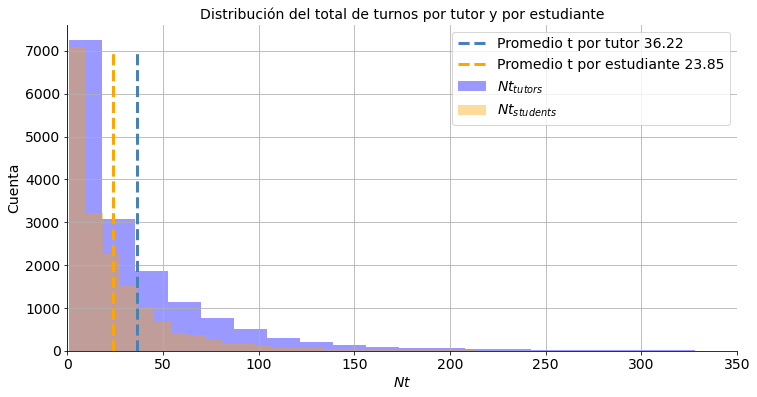

In [ ]:
plt.figure(figsize=(12,6))
sns.distplot(st_turnos[st_turnos.sent_from=='tutor'].counts.dropna(), kde=False, label=r'$Nt_{tutors}$', color='blue') #kde=False,
sns.distplot(st_turnos[st_turnos.sent_from=='student'].counts.dropna(), kde=False, label=r'$Nt_{students}$', color='orange')
plt.plot([mean_tutors, mean_tutors], [0,7050], '--b', linewidth=3, label=f'Promedio t por tutor {mean_tutors:.2f}', color='steelblue')
plt.plot([mean_students, mean_students], [0,7050], '--g', linewidth=3, label=f'Promedio t por estudiante {mean_students:.2f}', color='orange')
plt.grid(True)
plt.title("Distribución del total de turnos por tutor y por estudiante", fontsize=14)
plt.xlabel(r'$Nt$', fontsize=14)
plt.ylabel('Cuenta', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.xlim([0,350])
#plt.ylim([0, 55])
sns.despine()

En el anterior histograma se evidencia que el promedio del nro. de turnos del tutor es mayor que el del estudiante, existiendo una diferencia de aprox. 12 turnos. Sin embargo, se evidencia en ambos histogramas que los valores máximo se presentan en un extremo del mismo y que la distribución es inversa ya que a medida que aumenta el nro. de turnos por diálogo disminuye la frecuencia de los mismos.




## Conclusión


* Un diálogo entre un tutor y un estudiante está formado aproximadamente por un promedio de 60 turnos.
* Los casos con más de 200 turnos son poco probales de acuerdo a los cálculos y el histograma gráficado.

Un aspecto de interés es la cantidad total de turnos discriminada entre estudiantes y tutores. Esto permite comparar la proporcion de participación de de ambos en el desarrollo de un diálogo, evidenciándose, en términos generales, que existe mayor participación del tutor en los diálogos.